<a href="https://colab.research.google.com/github/HagenMarin/Histopathology-Cancer-Detection/blob/main/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Histopathology-Cancer-Detection
This is the Collab for our Group Project: Histopathology-Cancer-Detection.
We are going to showcase the Data used in this project, test our two most promising Models, compare them and in the end show some Classification examples and Class Activation Maps.

### Setup

In [1]:
!git clone https://github.com/HagenMarin/Histopathology-Cancer-Detection.git
%cd /content/Histopathology-Cancer-Detection
!git pull
!pip install grad-cam
from google.colab import drive
drive.mount('/content/drive')

Cloning into 'Histopathology-Cancer-Detection'...
remote: Enumerating objects: 146, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 146 (delta 17), reused 18 (delta 6), pack-reused 109
Receiving objects: 100% (146/146), 46.77 MiB | 28.53 MiB/s, done.
Resolving deltas: 100% (80/80), done.
/content/Histopathology-Cancer-Detection
Already up to date.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 14.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38245 sha256=b9ade21e5a8d96cc5fe73258e5654af7e953bafa2a5b07d01ad80a574c65f1be
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam
Mounted at /content/drive


In [2]:
import cv2
from google.colab.patches import cv2_imshow
import torch
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import pandas as pd
from tabulate import tabulate
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad, LayerCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from architecture import ResNet18
from architecture import ResNet
from architecture import BasicBlock
from data_loading import get_num_pos_samples_and_size
from data_loading import dataIterator
from data_loading import loadDataframe
from data_loading import iterate_test_batches
from test_collab import metrics_test
from test_collab import metrics_test_TTA

### Dataimport

In [3]:
# Change the Path to a folder on your Drive containing the train_labels.csv file
df = loadDataframe('/content/drive/MyDrive/Histopathology-Cancer-Detection/')

### Class Distributions

Text(0.5, 0.98, 'Classdistribution over whole Dataset')

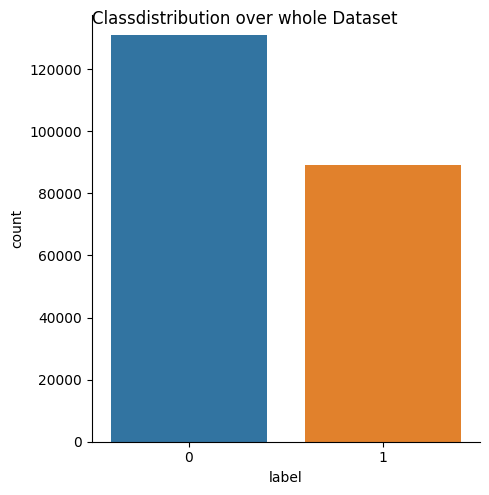

In [4]:
catplot = sns.catplot(data=df,x='label',kind="count")
catplot.fig.suptitle('Classdistribution over whole Dataset')

Text(0.5, 0.98, 'Classdistribution over training set')

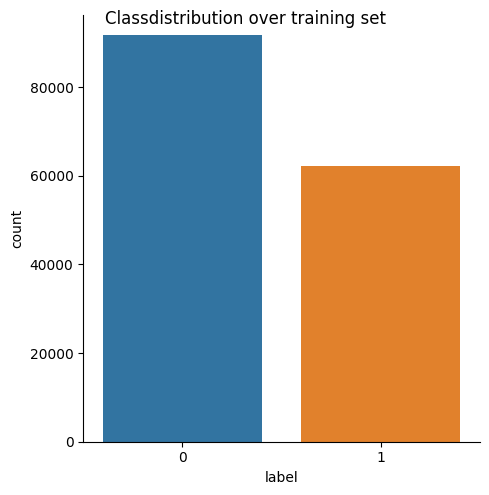

In [5]:
num_pos, size = get_num_pos_samples_and_size(df,128,0,0.7,0.15)
data_arr = []
for i in range(size):
  if i < num_pos:
    data_arr.append([1])
  else:
    data_arr.append([0])
train_set_numbers = pd.DataFrame(data = data_arr, columns=['label'])
catplot = sns.catplot(data=train_set_numbers,x='label',kind="count")
catplot.fig.suptitle('Classdistribution over training set')

Text(0.5, 0.98, 'Classdistribution over validation set')

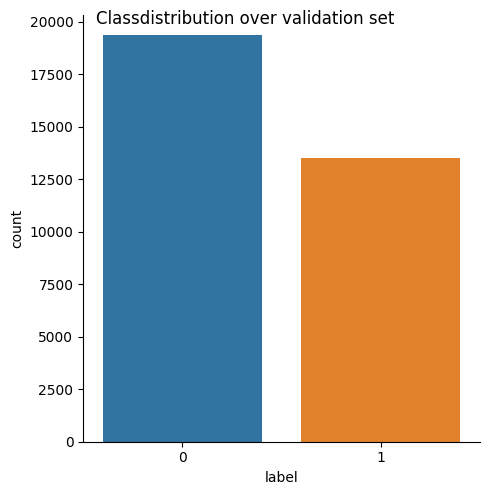

In [6]:
num_pos, size = get_num_pos_samples_and_size(df,128,1,0.7,0.15)
val_data_arr = []
for i in range(size):
  if i < num_pos:
    val_data_arr.append([1])
  else:
    val_data_arr.append([0])
val_set_numbers = pd.DataFrame(data = val_data_arr, columns=['label'])
catplot = sns.catplot(data=val_set_numbers,x='label',kind="count")
catplot.fig.suptitle('Classdistribution over validation set')

Text(0.5, 0.98, 'Classdistribution over test set')

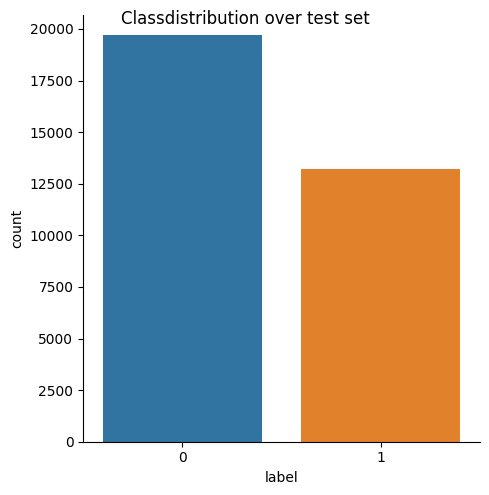

In [7]:
num_pos, size = get_num_pos_samples_and_size(df,128,2,0.7,0.15)
test_data_arr = []
for i in range(size):
  if i < num_pos:
    test_data_arr.append([1])
  else:
    test_data_arr.append([0])
test_set_numbers = pd.DataFrame(data = test_data_arr, columns=['label'])
catplot = sns.catplot(data=test_set_numbers,x='label',kind="count")
catplot.fig.suptitle('Classdistribution over test set')

### Loading the Models and testing them

In [8]:
resnet18 = ResNet18(img_channels=3, num_layers=18, block=BasicBlock, num_classes=1)
# Change the Path to the Saved Model Pickle file
resnet18.load_state_dict(torch.load('/content/Histopathology-Cancer-Detection/model/ResNet18Holdout_2dropout.pickle'))
resnet10 = ResNet()
# Change the Path to the Saved Model Pickle file
resnet10.load_state_dict(torch.load('/content/Histopathology-Cancer-Detection/model/ResNet_ta_0.9175442351598173_va_0.8829195205479452.pickle'))
use_cuda = torch.cuda.is_available()
    #for debugging it is sometimes useful to set the device to cpu as it usually gives more meaningful error messages
    #device = torch.device("cpu")
device = torch.device("cuda" if use_cuda else "cpu")
resnet18.to(device)
resnet10.to(device)
# Change the Path to the folder containing the directory test_batches128 with the generated test batches inside
path = '/content/drive/MyDrive/Histopathology-Cancer-Detection/'
resnet18_all_labels_TTA, resnet18_all_class_preds_TTA, resnet18_accuracy_TTA,resnet18_f1_score_TTA,resnet18_auc_score_TTA, resnet18_recall_TTA = metrics_test_TTA(resnet18,device,path)
resnet18_all_labels, resnet18_all_class_preds, resnet18_accuracy,resnet18_f1_score,resnet18_auc_score, resnet18_recall = metrics_test(resnet18,device,path)
resnet10_all_labels_TTA, resnet10_all_class_preds_TTA, resnet10_accuracy_TTA,resnet10_f1_score_TTA,resnet10_auc_score_TTA, resnet10_recall_TTA = metrics_test_TTA(resnet10,device,path)
resnet10_all_labels, resnet10_all_class_preds, resnet10_accuracy,resnet10_f1_score,resnet10_auc_score, resnet10_recall = metrics_test(resnet10,device,path)

In [9]:
table = [['accuracy', 'f1_score', 'auc_score', 'recall'], ['ResNet18 with TTA',resnet18_accuracy_TTA, resnet18_f1_score_TTA, resnet18_auc_score_TTA, resnet18_recall_TTA], ['ResNet18 without TTA',resnet18_accuracy, resnet18_f1_score, resnet18_auc_score, resnet18_recall],['ResNet10 with TTA',resnet10_accuracy_TTA, resnet10_f1_score_TTA, resnet10_auc_score_TTA, resnet10_recall_TTA], ['ResNet10 without TTA',resnet10_accuracy, resnet10_f1_score, resnet10_auc_score, resnet10_recall]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒══════════════════════╤════════════╤════════════╤═════════════╤══════════╕
│                      │   accuracy │   f1_score │   auc_score │   recall │
╞══════════════════════╪════════════╪════════════╪═════════════╪══════════╡
│ ResNet18 with TTA    │   0.885001 │   0.856634 │    0.951344 │ 0.855758 │
├──────────────────────┼────────────┼────────────┼─────────────┼──────────┤
│ ResNet18 without TTA │   0.878861 │   0.849481 │    0.948967 │ 0.851442 │
├──────────────────────┼────────────┼────────────┼─────────────┼──────────┤
│ ResNet10 with TTA    │   0.737992 │   0.661376 │    0.816318 │ 0.637314 │
├──────────────────────┼────────────┼────────────┼─────────────┼──────────┤
│ ResNet10 without TTA │   0.885244 │   0.854095 │    0.951285 │ 0.836602 │
╘══════════════════════╧════════════╧════════════╧═════════════╧══════════╛


### Confusion Matrices

In [10]:
DetaFrame_cm_resnet18_TTA = pd.DataFrame(confusion_matrix(resnet18_all_labels_TTA, resnet18_all_class_preds_TTA), ['predicted 0','predicted 1'], ['true 0','true 1'])
DetaFrame_cm_resnet18 = pd.DataFrame(confusion_matrix(resnet18_all_labels, resnet18_all_class_preds), ['predicted 0','predicted 1'], ['true 0','true 1'])
DetaFrame_cm_resnet10_TTA = pd.DataFrame(confusion_matrix(resnet10_all_labels_TTA, resnet10_all_class_preds_TTA), ['predicted 0','predicted 1'], ['true 0','true 1'])
DetaFrame_cm_resnet10 = pd.DataFrame(confusion_matrix(resnet10_all_labels, resnet10_all_class_preds), ['predicted 0','predicted 1'], ['true 0','true 1'])

Text(0.5, 1.0, 'Confusion Matrix ResNet18 with TTA')

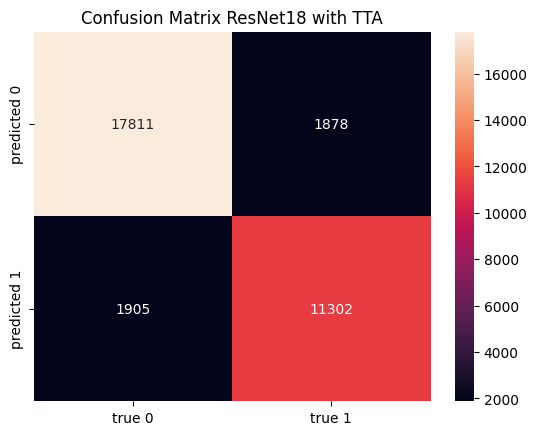

In [11]:
heatmap1 = sns.heatmap(DetaFrame_cm_resnet18_TTA, annot=True, fmt="d")
heatmap1.set_title('Confusion Matrix ResNet18 with TTA')

Text(0.5, 1.0, 'Confusion Matrix ResNet18 without TTA')

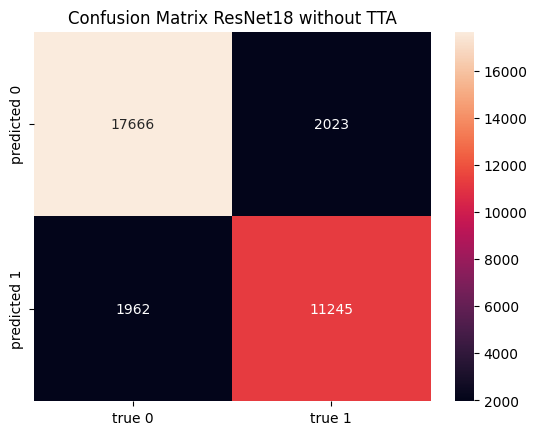

In [12]:
heatmap2 = sns.heatmap(DetaFrame_cm_resnet18, annot=True, fmt="d")
heatmap2.set_title('Confusion Matrix ResNet18 without TTA')

Text(0.5, 1.0, 'Confusion Matrix ResNet10 with TTA')

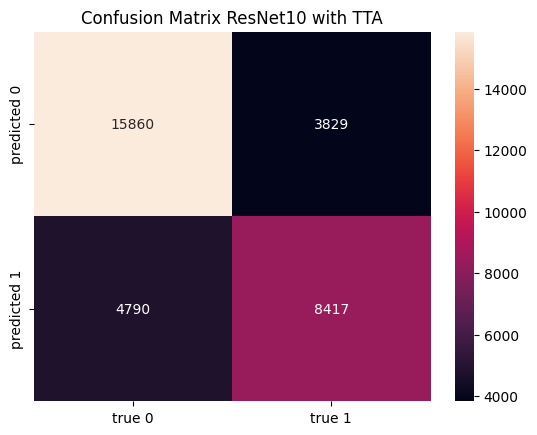

In [13]:
heatmap3 = sns.heatmap(DetaFrame_cm_resnet10_TTA, annot=True, fmt="d")
heatmap3.set_title('Confusion Matrix ResNet10 with TTA')

Text(0.5, 1.0, 'Confusion Matrix ResNet10 without TTA')

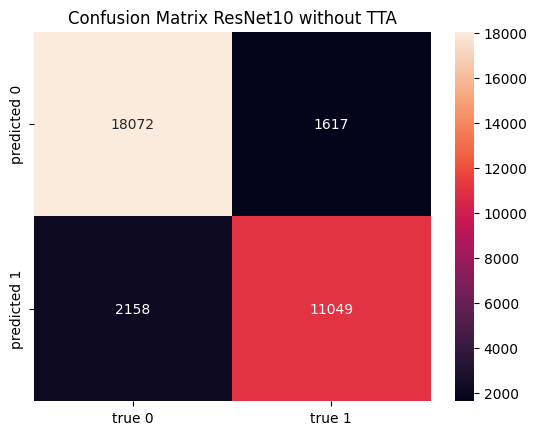

In [14]:
heatmap4 = sns.heatmap(DetaFrame_cm_resnet10, annot=True, fmt="d")
heatmap4.set_title('Confusion Matrix ResNet10 without TTA')

### Classification Examples and Layer Activation Maps

Image:


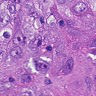

Class Activation Map for Layer4:


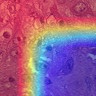

Prediction:0.9913150668144226
True Class:1.0
Image:


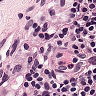

Class Activation Map for Layer4:


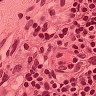

Prediction:0.012131590396165848
True Class:0.0
Image:


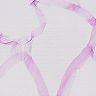

Class Activation Map for Layer4:


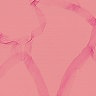

Prediction:0.00015152135165408254
True Class:0.0
Image:


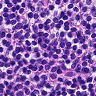

Class Activation Map for Layer4:


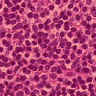

Prediction:0.005879050586372614
True Class:0.0
Image:


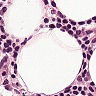

Class Activation Map for Layer4:


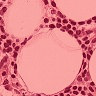

Prediction:0.025635600090026855
True Class:0.0


In [15]:
for images, labels in iterate_test_batches(dir = path):
  images = images.to(device)
  with torch.no_grad():
    outputs = resnet18(images)
    for i in range(4):
      outputs = torch.cat((outputs,resnet18(images)),1)
    outputs = torch.mean(outputs,1,True)
  target_layers = [resnet18.layer4]
  resnet18.eval()
  # Construct the CAM object once, and then re-use it on many images:
  cam = GradCAM(model=resnet18, target_layers=target_layers)

  targets = [ClassifierOutputTarget(0) for i in range(128)]
  grayscale_cams = cam(input_tensor=images, targets=targets)
  #print(grayscale_cam.shape)
  # In this example grayscale_cam has only one image in the batch:
  print('Image:')
  cv2_imshow(images[0].cpu().numpy().reshape((96,96,3))*255)
  grayscale_cam = grayscale_cams[0]
  visualization = show_cam_on_image(images[0].cpu().numpy().reshape((96,96,3)), grayscale_cam, use_rgb=True)
  print('Class Activation Map for Layer4:')
  cv2_imshow(visualization)
  print('Prediction:' + str(outputs[0].item()))
  print('True Class:' + str(labels[0].item()))
  print('Image:')
  cv2_imshow(images[1].cpu().numpy().reshape((96,96,3))*255)
  grayscale_cam = grayscale_cams[1]
  visualization = show_cam_on_image(images[1].cpu().numpy().reshape((96,96,3)), grayscale_cam, use_rgb=True)
  print('Class Activation Map for Layer4:')
  cv2_imshow(visualization)
  print('Prediction:' + str(outputs[1].item()))
  print('True Class:' + str(labels[1].item()))
  print('Image:')
  cv2_imshow(images[2].cpu().numpy().reshape((96,96,3))*255)
  grayscale_cam = grayscale_cams[2]
  visualization = show_cam_on_image(images[2].cpu().numpy().reshape((96,96,3)), grayscale_cam, use_rgb=True)
  print('Class Activation Map for Layer4:')
  cv2_imshow(visualization)
  print('Prediction:' + str(outputs[2].item()))
  print('True Class:' + str(labels[2].item()))
  print('Image:')
  cv2_imshow(images[3].cpu().numpy().reshape((96,96,3))*255)
  grayscale_cam = grayscale_cams[3]
  visualization = show_cam_on_image(images[3].cpu().numpy().reshape((96,96,3)), grayscale_cam, use_rgb=True)
  print('Class Activation Map for Layer4:')
  cv2_imshow(visualization)
  print('Prediction:' + str(outputs[3].item()))
  print('True Class:' + str(labels[3].item()))
  print('Image:')
  cv2_imshow(images[4].cpu().numpy().reshape((96,96,3))*255)
  grayscale_cam = grayscale_cams[4]
  visualization = show_cam_on_image(images[4].cpu().numpy().reshape((96,96,3)), grayscale_cam, use_rgb=True)
  print('Class Activation Map for Layer4:')
  cv2_imshow(visualization)
  print('Prediction:' + str(outputs[4].item()))
  print('True Class:' + str(labels[4].item()))
  break